In [27]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

[master 3e453499] From Mac
 2 files changed, 1834 insertions(+), 3150 deletions(-)
 rewrite NeuralNetwork/AAE/.ipynb_checkpoints/00 AAE Duplicate paper -checkpoint.ipynb (65%)
 rewrite NeuralNetwork/AAE/00 AAE Duplicate paper .ipynb (65%)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 47.68 KiB | 1.70 MiB/s, done.
Total 6 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   25397366..3e453499  master -> master


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((5000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for x in range(5000):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(5000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


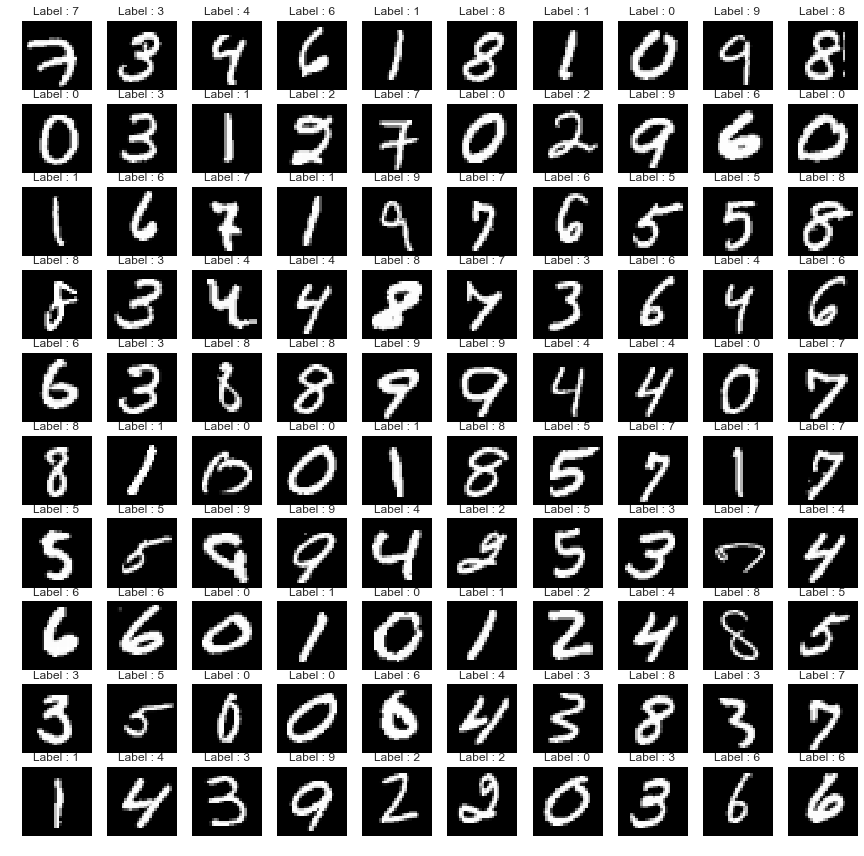

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [28]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x): return x

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0.0),tf.float32)

def tf_lrelu(x): return tf.nn.leaky_relu(x,alpha=0.85)
def d_tf_lrelu(x): return tf.cast(tf.greater(x,0),tf.float32) + tf.cast(tf.less_equal(x,0),tf.float32) * 0.85

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
            self.b = tf.Variable(tf.random_uniform(shape=(outc),     minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
            self.b = tf.Variable(tf.random_normal([outc],     stddev=0.05,seed=2,dtype=tf.float32))
        self.m,self.v     = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer) 
        return self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===        
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w
            grad_b=grad_b + lamda * 2.0 * self.b

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []
        
        # Update the Weight First         
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        # Update the Bias later
        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b )))        
        
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [33]:
# hyper class
num_epoch = 101; learning_rate = 0.0008 ; batch_size = 100; print_size = 2
lamda = 0.00
beta1,beta2,adam_e = 0.9,0.999,1e-8

e1 = FNN(784,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
e2 = FNN(1000,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
e3 = FNN(1000,2,which_reg=0.0,act=tf_identiy,d_act=tf_identiy)

d1 = FNN(2,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
d2 = FNN(1000,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
d3 = FNN(1000,784,which_reg=0.0,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [34]:
# encoding/decoding (feed forward)
x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)

elayer1 = e1.feedforward(x)
elayer2 = e2.feedforward(elayer1)
elayer3 = e3.feedforward(elayer2)

dlayer1 = d1.feedforward(elayer3)
dlayer2 = d2.feedforward(dlayer1)
dlayer3 = d3.feedforward(dlayer2)

print(elayer1,elayer2)
print(elayer3)
print(dlayer1,dlayer2)
print(dlayer3)

Tensor("Relu_21:0", shape=(100, 1000), dtype=float32) Tensor("Relu_22:0", shape=(100, 1000), dtype=float32)
Tensor("add_130:0", shape=(100, 2), dtype=float32)
Tensor("Relu_23:0", shape=(100, 1000), dtype=float32) Tensor("Relu_24:0", shape=(100, 1000), dtype=float32)
Tensor("Sigmoid_13:0", shape=(100, 784), dtype=float32)


In [35]:
# encoding / decoding (back prop)
recon_cost = tf.reduce_mean(tf.square(dlayer3-x))
total_cost = recon_cost

recon_grad = dlayer3 - x
total_grad = recon_grad/batch_size

dgrad3,dgrad3_up = d3.backprop(total_grad)
dgrad2,dgrad2_up = d2.backprop(dgrad3)
dgrad1,dgrad1_up = d1.backprop(dgrad2)

egrad3,egrad3_up = e3.backprop(dgrad1)
egrad2,egrad2_up = e2.backprop(egrad3)
egrad1,egrad1_up = e1.backprop(egrad2)

grad_update = dgrad3_up + dgrad2_up + dgrad1_up + \
              egrad3_up + egrad2_up + egrad1_up 

print(dgrad3)
print(dgrad2,dgrad1)
print(egrad3)
print(egrad2,egrad1)

Tensor("MatMul_66:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_68:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_70:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_72:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_74:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_76:0", shape=(100, 784), dtype=float32)


 iter: 0 batch: 4900 cost: 0.126284446

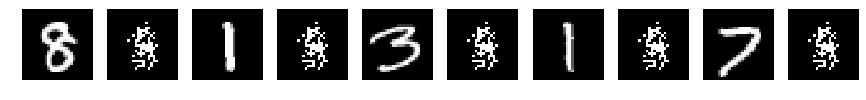

 iter: 2 batch: 4900 cost: 0.132678786

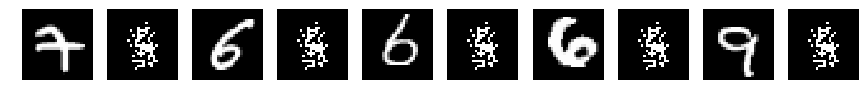

 iter: 4 batch: 4900 cost: 0.131722645

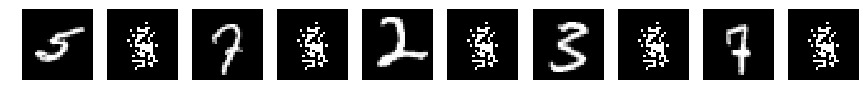

 iter: 6 batch: 4900 cost: 0.129914364

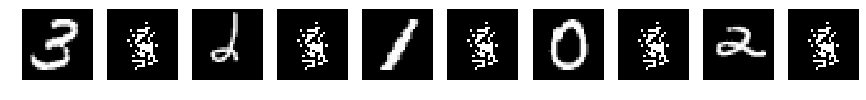

 iter: 8 batch: 4900 cost: 0.130963495

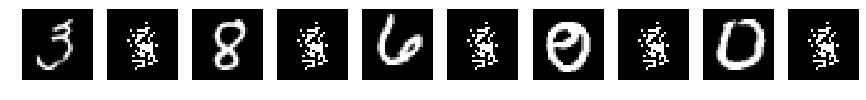

 iter: 10 batch: 4900 cost: 0.127332085

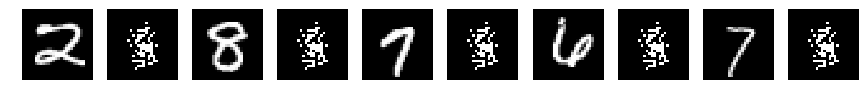

 iter: 12 batch: 4900 cost: 0.125016124

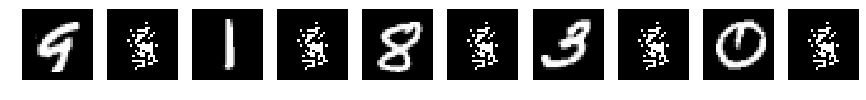

 iter: 14 batch: 4900 cost: 0.125632154

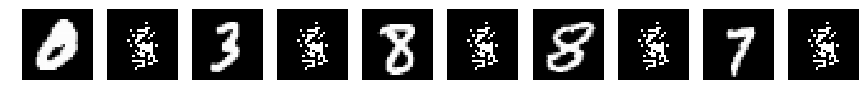

 iter: 16 batch: 4900 cost: 0.124885035

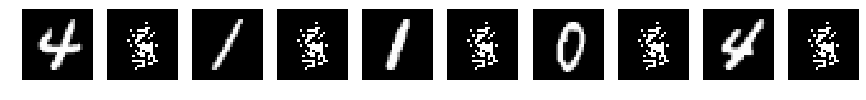

 iter: 18 batch: 4900 cost: 0.12370558

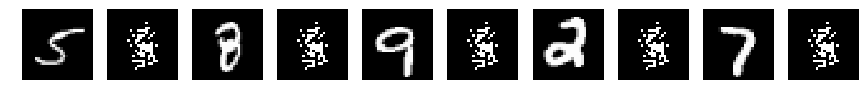

 iter: 20 batch: 4900 cost: 0.124229964

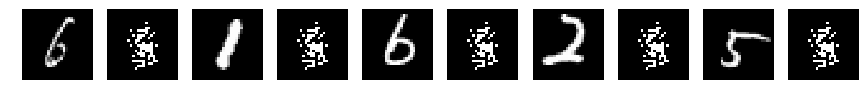

 iter: 22 batch: 4900 cost: 0.125730866

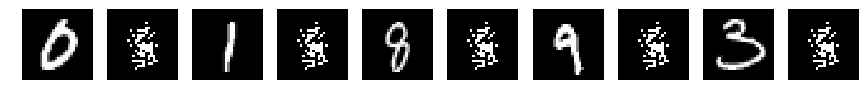

 iter: 24 batch: 4900 cost: 0.123695145

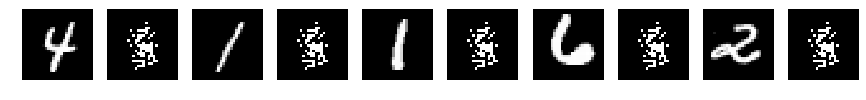

 iter: 26 batch: 4900 cost: 0.123145655

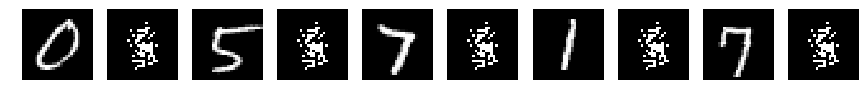

 iter: 28 batch: 4900 cost: 0.125574454

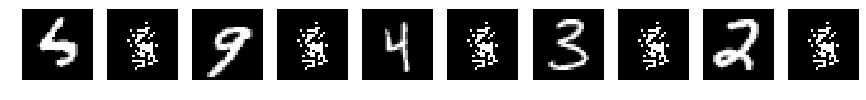

 iter: 30 batch: 4900 cost: 0.129368764

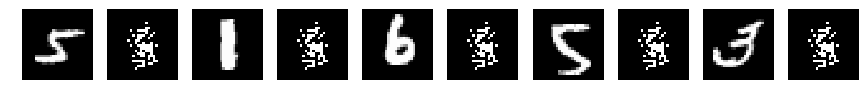

 iter: 32 batch: 4900 cost: 0.130470725

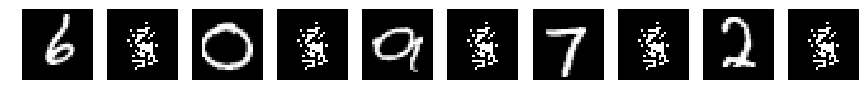

 iter: 34 batch: 4900 cost: 0.119973054

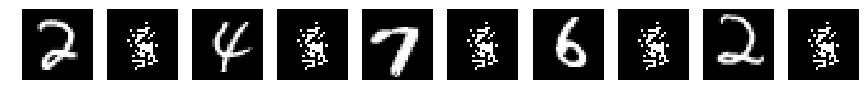

 iter: 36 batch: 4900 cost: 0.126398674

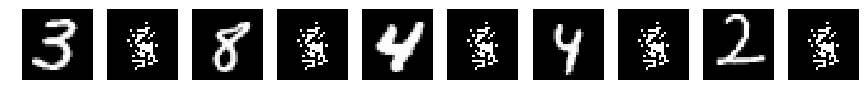

 iter: 38 batch: 4900 cost: 0.123190536

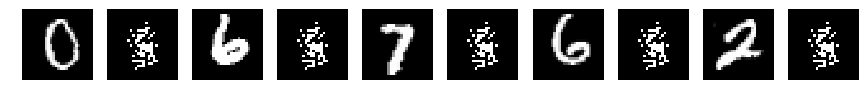

 iter: 40 batch: 4900 cost: 0.127556744

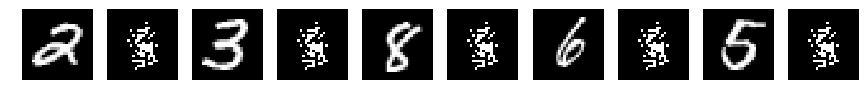

 iter: 42 batch: 4900 cost: 0.123685236

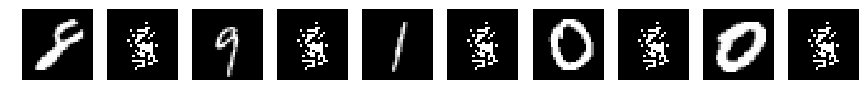

 iter: 44 batch: 4900 cost: 0.125387675

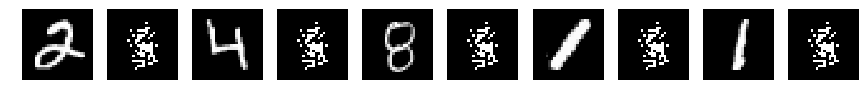

 iter: 46 batch: 4900 cost: 0.128323235

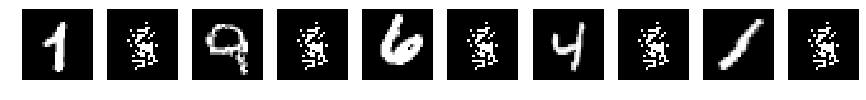

 iter: 48 batch: 4900 cost: 0.132899334

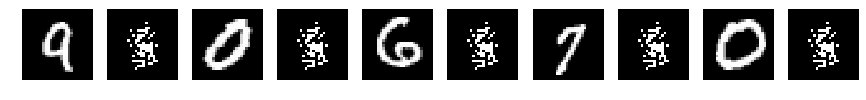

 iter: 50 batch: 4900 cost: 0.133596914

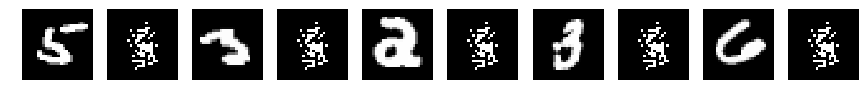

 iter: 52 batch: 4900 cost: 0.126279196

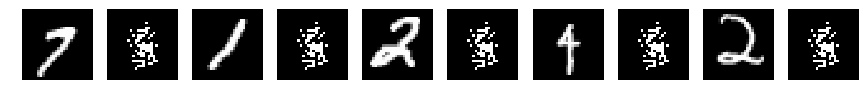

 iter: 54 batch: 4900 cost: 0.126870876

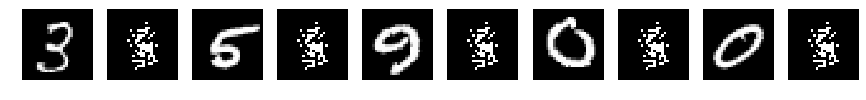

 iter: 55 batch: 3500 cost: 0.127350885

In [ ]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()

for iter in range(num_epoch):
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        sess_result = sess.run([total_cost,grad_update],feed_dict={x:current_data.reshape((batch_size,-1))})
        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + ' cost: ' + str(sess_result[0])
        )
        sys.stdout.flush()
        
    if iter % print_size == 0:
        sess_result = sess.run(dlayer3,feed_dict={x:current_data.reshape((batch_size,-1))}).reshape((batch_size,28,28))
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()
        
        train_batch_shuffled = shuffle(train_batch_shuffled)

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer4,feed_dict={x:train_batch[:batch_size]})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer4,feed_dict={x:current_train_data})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()